In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dropout


In [9]:
import pandas as pd

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:

mydata = pd.read_csv('/content/drive/MyDrive/Copy of twcs.csv',encoding='utf-8')
print(mydata.shape)
mydata.head()

(2811774, 7)


,tweet_id,author_id,inbound,created_at,text,response_tweet_id,in_response_to_tweet_id
0,1,sprintcare,False,Tue Oct 31 22:10:47 +0000 2017,@115712 I understand. I would like to assist y...,2,3.0
1,2,115712,True,Tue Oct 31 22:11:45 +0000 2017,@sprintcare and how do you propose we do that,NaN,1.0
2,3,115712,True,Tue Oct 31 22:08:27 +0000 2017,@sprintcare I have sent several private messag...,1,4.0
3,4,sprintcare,False,Tue Oct 31 21:54:49 +0000 2017,@115712 Please send us a Private Message so th...,3,5.0
4,5,115712,True,Tue Oct 31 21:49:35 +0000 2017,@sprintcare I did.,4,6.0


In [12]:
first_inbound = mydata[pd.isnull(mydata.in_response_to_tweet_id) & mydata.inbound]

df1 = pd.merge(first_inbound, mydata, left_on='tweet_id', 
                                  right_on='in_response_to_tweet_id')

# Filter to only outbound replies (from companies)
df1 = df1[df1.inbound_y ^ True]
print(f'Data shape: {df1.shape}')
df1.head()

Data shape: (794299, 14)


,tweet_id_x,author_id_x,inbound_x,created_at_x,text_x,response_tweet_id_x,in_response_to_tweet_id_x,tweet_id_y,author_id_y,inbound_y,created_at_y,text_y,response_tweet_id_y,in_response_to_tweet_id_y
0,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,6,sprintcare,False,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...,"5,7",8.0
1,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,9,sprintcare,False,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...,NaN,8.0
2,8,115712,True,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,"9,6,10",NaN,10,sprintcare,False,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...,NaN,8.0
3,18,115713,True,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,17,NaN,17,sprintcare,False,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...,16,18.0
4,20,115715,True,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",19,NaN,19,sprintcare,False,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...,NaN,20.0


In [13]:

df1 = df1[["author_id_x","created_at_x","text_x","author_id_y","created_at_y","text_y"]]
df1.reset_index(inplace=True)
df1.head(5)

,index,author_id_x,created_at_x,text_x,author_id_y,created_at_y,text_y
0,0,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:24 +0000 2017,@115712 Can you please send us a private messa...
1,1,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:46:14 +0000 2017,@115712 I would love the chance to review the ...
2,2,115712,Tue Oct 31 21:45:10 +0000 2017,@sprintcare is the worst customer service,sprintcare,Tue Oct 31 21:45:59 +0000 2017,@115712 Hello! We never like our customers to ...
3,3,115713,Tue Oct 31 19:56:01 +0000 2017,@115714 y’all lie about your “great” connectio...,sprintcare,Tue Oct 31 19:59:13 +0000 2017,@115713 H there! We'd definitely like to work ...
4,4,115715,Tue Oct 31 22:03:34 +0000 2017,"@115714 whenever I contact customer support, t...",sprintcare,Tue Oct 31 22:10:10 +0000 2017,@115715 Please send me a private message so th...


In [14]:
# Subseting only Dependent variable and Independent Variable
df = df1[['text_x', 'author_id_y']]
df.head(5)

,text_x,author_id_y
0,@sprintcare is the worst customer service,sprintcare
1,@sprintcare is the worst customer service,sprintcare
2,@sprintcare is the worst customer service,sprintcare
3,@115714 y’all lie about your “great” connectio...,sprintcare
4,"@115714 whenever I contact customer support, t...",sprintcare


In [15]:
df['author_id_y'].value_counts()

AmazonHelp         84637
AppleSupport       74632
Uber_Support       40029
Delta              28485
SpotifyCares       26940
                   ...  
mediatemplehelp      190
AskDSC               189
CarlsJr              138
HotelTonightCX       131
OfficeSupport         58
Name: author_id_y, Length: 108, dtype: int64

In [16]:
# Top four company name get most of the mail and response to customer
df=df[(df['author_id_y']=='SpotifyCares')+(df['author_id_y']=='AmazonHelp')+(df['author_id_y']=='Uber_Support')+(df['author_id_y']=='AppleSupport')]


/usr/local/lib/python3.7/dist-packages/pandas/core/computation/expressions.py:204: UserWarning: evaluating in Python space because the '+' operator is not supported by numexpr for the bool dtype, use '|' instead
  f"evaluating in Python space because the {repr(op_str)} "


In [17]:
df['author_id_y'].value_counts()

AmazonHelp      84637
AppleSupport    74632
Uber_Support    40029
SpotifyCares    26940
Name: author_id_y, dtype: int64

In [18]:
df['author_id_y'].value_counts()

AmazonHelp      84637
AppleSupport    74632
Uber_Support    40029
SpotifyCares    26940
Name: author_id_y, dtype: int64

In [19]:
import re
def process_textx(text_x):
    return " ".join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])", " ",text_x.lower()).split())

In [20]:
df['cleaned_textx'] = df['text_x'].apply(process_textx)

In [21]:
possible_labels = df.author_id_y.unique()

label_dict = {}
for index, possible_label in enumerate(possible_labels):
    label_dict[possible_label] = index
label_dict

{'AmazonHelp': 0, 'AppleSupport': 1, 'SpotifyCares': 3, 'Uber_Support': 2}

In [22]:
df['label'] = df.author_id_y.replace(label_dict)
df.shape


(226238, 4)

In [23]:
df.head()


,text_x,author_id_y,cleaned_textx,label
45,amazonのfireTVstickが見れない😢,AmazonHelp,amazon firetvstick,0
58,amazonプライムビデオ、再生エラーが多いです,AmazonHelp,amazon,0
73,Way to drop the ball on customer service @1158...,AmazonHelp,way to drop the ball on customer service so pi...,0
74,@115823 I want my amazon payments account CLOS...,AmazonHelp,i want my amazon payments account closed dm me...,0
75,"@115825 also, beim Addams Family-Film in Prime...",AmazonHelp,also beim addams family film in prime sind bil...,0


In [24]:
df['label'].value_counts().sum()

226238

In [25]:
from tensorflow.keras.preprocessing.text import one_hot
voc_size=5000
onehot_repre=[one_hot(words,voc_size)for words in df['cleaned_textx']]

In [26]:
onehot_repre

[[2970, 1532],
 [2970],
 [2867, 1549, 3694, 3785, 2290, 1415, 390, 1598, 3305, 3898, 1741, 1917],
 [4119, 1466, 3653, 2970, 3930, 1447, 403, 4589, 2485, 2628],
 [684,
  4325,
  3950,
  56,
  2055,
  2628,
  3526,
  1148,
  465,
  275,
  317,
  2377,
  2684,
  1631,
  691,
  413,
  1938],
 [3653,
  4918,
  2260,
  72,
  3159,
  1775,
  2109,
  1893,
  4793,
  4143,
  1310,
  1412,
  1188,
  4767,
  4713,
  2727,
  692,
  928,
  917],
 [1832,
  4043,
  3653,
  2888,
  664,
  3653,
  78,
  3225,
  3987,
  3785,
  4138,
  2494,
  1955,
  4262,
  2750,
  4062,
  692,
  4057,
  3360,
  1549,
  2485,
  3690,
  3237,
  3315,
  2541],
 [902,
  3987,
  3785,
  2891,
  1067,
  4270,
  4119,
  3403,
  4792,
  634,
  2727,
  692,
  928,
  4596],
 [4911,
  373,
  4499,
  3240,
  4262,
  4698,
  4741,
  692,
  142,
  4109,
  4969,
  1447,
  2628,
  3301,
  4216,
  3719,
  703],
 [666,
  1889,
  4141,
  4057,
  3360,
  3896,
  2066,
  2765,
  4698,
  2260,
  1070,
  1549,
  2485,
  3690,
  373,
  3467

In [27]:
sent_length=20
embedding_docs=pad_sequences(onehot_repre,padding='pre',maxlen=sent_length)

In [28]:
embedding_docs

array([[   0,    0,    0, ...,    0, 2970, 1532],
       [   0,    0,    0, ...,    0,    0, 2970],
       [   0,    0,    0, ..., 3898, 1741, 1917],
       ...,
       [   0,    0,    0, ...,  692,  928,  582],
       [   0,    0, 1983, ...,  692,  928,  111],
       [   0,    0,    0, ...,  692,  928, 3159]], dtype=int32)

In [29]:
x_final=np.array(embedding_docs)
y_final=np.array(df['label'])

In [30]:
y_final

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
x_final

array([[   0,    0,    0, ...,    0, 2970, 1532],
       [   0,    0,    0, ...,    0,    0, 2970],
       [   0,    0,    0, ..., 3898, 1741, 1917],
       ...,
       [   0,    0,    0, ...,  692,  928,  582],
       [   0,    0, 1983, ...,  692,  928,  111],
       [   0,    0,    0, ...,  692,  928, 3159]], dtype=int32)

In [32]:
x_final.shape,y_final.shape

((226238, 20), (226238,))

In [33]:

from sklearn.svm import SVC
from sklearn import svm, datasets
import sklearn.model_selection as model_selection

In [34]:
import tensorflow as tf


In [35]:
tf.__version__

'2.4.1'

In [36]:

len(embedding_docs),df['label'].shape

(226238, (226238,))

In [37]:
embedding_docs[10]

array([   0, 2628, 1813, 1549, 2850, 2623, 1809,  825, 4997, 2260, 3987,
       4109, 3372,  295, 4387, 1023, 2727,  692,  928, 4453], dtype=int32)

In [39]:

embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100)))
model1.add(Dropout(0.3))
model1.add(Dense(4,activation='relu'))
model1.add(Dense(4,activation='softmax'))
model1.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 40)            200000    
_________________________________________________________________
bidirectional (Bidirectional (None, 200)               112800    
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 804       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 20        
Total params: 313,624
Trainable params: 313,624
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x_final,y_final,test_size=0.25,random_state=40)

In [41]:
x_train.shape,y_train.shape

((169678, 20), (169678,))

In [42]:
x_test.shape,y_test.shape

((56560, 20), (56560,))

In [43]:
model1.fit(x_train,y_train,validation_data=(x_test,y_test),epochs=10,batch_size=64)

Epoch 1/10
2652/2652 [==============================] - 61s 10ms/step - loss: 0.8031 - accuracy: 0.6722 - val_loss: 0.4085 - val_accuracy: 0.8540
Epoch 2/10
2652/2652 [==============================] - 26s 10ms/step - loss: 0.3896 - accuracy: 0.8620 - val_loss: 0.3759 - val_accuracy: 0.8626
Epoch 3/10
2652/2652 [==============================] - 26s 10ms/step - loss: 0.3476 - accuracy: 0.8750 - val_loss: 0.3703 - val_accuracy: 0.8642
Epoch 4/10
2652/2652 [==============================] - 25s 9ms/step - loss: 0.3191 - accuracy: 0.8839 - val_loss: 0.3687 - val_accuracy: 0.8653
Epoch 5/10
2652/2652 [==============================] - 25s 10ms/step - loss: 0.2956 - accuracy: 0.8927 - val_loss: 0.3748 - val_accuracy: 0.8658
Epoch 6/10
2652/2652 [==============================] - 26s 10ms/step - loss: 0.2721 - accuracy: 0.9017 - val_loss: 0.3937 - val_accuracy: 0.8600
Epoch 7/10
2652/2652 [==============================] - 25s 9ms/step - loss: 0.2479 - accuracy: 0.9097 - val_loss: 0.4127 - v

In [44]:
y_predict_test=model1.predict_classes(x_test)
y_predict_train=model1.predict_classes(x_train)

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [45]:
y_predict_test

array([1, 1, 3, ..., 3, 3, 1])

In [46]:
y_predict_train

array([1, 1, 2, ..., 0, 0, 1])

In [47]:
from sklearn.metrics import confusion_matrix
confusion_metrix=confusion_matrix(y_test,y_predict_test)
confusion_metrix

array([[18912,  1087,   607,   670],
       [ 1152, 16496,   310,   679],
       [ 1089,   443,  8105,   379],
       [  657,   665,   215,  5094]])

In [48]:
from sklearn.metrics import classification_report,plot_confusion_matrix
print(classification_report(y_test,y_predict_test))

              precision    recall  f1-score   support

           0       0.87      0.89      0.88     21276
           1       0.88      0.89      0.88     18637
           2       0.88      0.81      0.84     10016
           3       0.75      0.77      0.76      6631

    accuracy                           0.86     56560
   macro avg       0.84      0.84      0.84     56560
weighted avg       0.86      0.86      0.86     56560



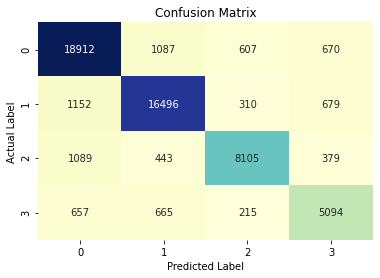

In [49]:
import seaborn as sns

sns.heatmap(confusion_matrix(y_test,y_predict_test),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()


In [50]:
print(classification_report(y_train,y_predict_train))

              precision    recall  f1-score   support

           0       0.95      0.96      0.95     63361
           1       0.96      0.96      0.96     55995
           2       0.96      0.91      0.94     30013
           3       0.89      0.91      0.90     20309

    accuracy                           0.95    169678
   macro avg       0.94      0.94      0.94    169678
weighted avg       0.95      0.95      0.95    169678



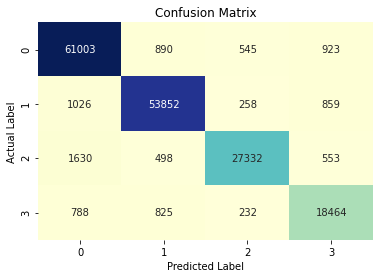

In [51]:
sns.heatmap(confusion_matrix(y_train,y_predict_train),annot=True, fmt='d', cbar=False,cmap='YlGnBu')
plt.xlabel('Predicted Label')
plt.ylabel('Actual Label')
plt.title('Confusion Matrix')
plt.show()